In [1]:
import numpy as np 
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pylab as plt 

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
class FirstModel:
    def __init__(self, domain, fiducial, noisecov):
        
        self.nparam = len(fiducial)
        self.domain = domain
        self.fiducial = fiducial
        
        # (N x p)
        self.gradient_fid = self.gradient(fiducial)
        
        # (N x p)
        self.b_matrix = np.linalg.inv(noisecov) @ self.gradient_fid
        
        # (p x p)
        self.Lambda = self.b_matrix.T @ noisecov @ self.b_matrix
        
        # theory of size N 
        self.theory_fid = self.function(fiducial)
        
    def function(self, parameters):
        mean = parameters[0] * np.sin(parameters[1] * self.domain)
        # mean = parameters[0] * self.domain**3 + parameters[1] * self.domain + parameters[2]
        return mean
        
    def gradient(self, parameters):
        gradient_param_0 = np.sin(parameters[1] * self.domain)
        gradient_param_1 = parameters[0] * self.domain * np.cos(parameters[1] * self.domain)
        grad = np.vstack([gradient_param_0, gradient_param_1]).T
        
        # grad = np.vstack([self.domain**3, self.domain, np.ones(len(self.domain))]).T
        return grad 

In [3]:
class SecondModel(FirstModel):
    
    def __init__(self, domain, fiducial1, fiducial2, noisecov):
        
        self.domain = domain 
        self.fiducial = fiducial2
        self.nparam = len(fiducial2)
        
        # the first model
        self.first_model = FirstModel(domain, fiducial1, noisecov)
        
        assert self.first_model.nparam >= self.nparam, 'Model 1 should have atleast the same number of parameters as Model 2'
        
        # (N x m)
        self.gradient_fid = self.gradient(fiducial2)
        
        # (m x p)
        self.b_matrix = self.gradient_fid.T @ self.first_model.b_matrix @ np.linalg.inv(self.first_model.Lambda)
        
        # (m x m)
        self.Lambda = self.b_matrix @ self.first_model.b_matrix.T @ self.gradient_fid
        
    def function(self, parameters):
        mean = parameters[0] * self.domain**3 + parameters[1] * self.domain
        return mean
    
    def gradient(self, parameters):
        grad = np.vstack([self.domain**3, self.domain]).T
        return grad

In [4]:
def evidence_full_data(data, cov_data, comp_data, comp_cov, cov_prior):
    invterm = np.linalg.inv(comp_cov + np.linalg.inv(cov_prior))
    det1 = np.linalg.slogdet(2.0 * np.pi * invterm)[1]
    det2 = np.linalg.slogdet(2.0 * np.pi * cov_data)[1]
    det3 = np.linalg.slogdet(2.0 * np.pi * cov_prior)[1]
    chi2_1 = data @ np.linalg.inv(cov_data) @ data
    chi2_2 = comp_data @ invterm @ comp_data
    evidence = 0.5 * (det1 - det2 - det3 - chi2_1 + chi2_2)
    return evidence

In [5]:
def evidence_comp_data_1(comp_data, comp_cov, cov_prior):
    invterm = np.linalg.inv(comp_cov + np.linalg.inv(cov_prior))
    det1 = np.linalg.slogdet(2.0 * np.pi * invterm)[1]
    det2 = np.linalg.slogdet(2.0 * np.pi * comp_cov)[1]
    det3 = np.linalg.slogdet(2.0 * np.pi * cov_prior)[1]
    chi2_1 = comp_data @ np.linalg.inv(comp_cov) @ comp_data
    chi2_2 = comp_data @ invterm @ comp_data
    evidence = 0.5 * (det1 - det2 - det3 - chi2_1 + chi2_2)
    return evidence

In [6]:
def evidence_comp_data_2(comp_data1, comp_data2, comp_cov1, comp_cov2, cov_prior):
    invterm = np.linalg.inv(comp_cov2 + np.linalg.inv(cov_prior))
    det1 = np.linalg.slogdet(2.0 * np.pi * invterm)[1]
    det2 = np.linalg.slogdet(2.0 * np.pi * comp_cov1)[1]
    det3 = np.linalg.slogdet(2.0 * np.pi * cov_prior)[1]
    chi2_1 = comp_data1 @ np.linalg.inv(comp_cov1) @ comp_data1
    chi2_2 = comp_data2 @ invterm @ comp_data2
    evidence = 0.5 * (det1 - det2 - det3 - chi2_1 + chi2_2)
    return evidence

In [7]:
class EvidenceAndBF:
    
    def __init__(self, domain, fiducial1, fiducial2, noisecov, covprior1, covprior2):
        
        self.noisecov = noisecov
        self.invnoise = np.linalg.inv(noisecov)
        
        self.covprior1 = covprior1
        self.covprior2 = covprior2
    
        self.models = SecondModel(domain, fiducial1, fiducial2, noisecov)
        
    def calculations(self, data):
        
        capital_x = data - self.models.first_model.theory_fid
        capital_y = self.models.first_model.b_matrix.T @ capital_x
        
        # for the second model, we need a modified compressed data, but the compressed data is fixed 
        capital_y2 = self.models.b_matrix @ capital_y
        
        # evidence for uncompressed data 
        evidence_1 = evidence_full_data(capital_x, self.noisecov, capital_y, self.models.first_model.Lambda, self.covprior1)
        evidence_2 = evidence_full_data(capital_x, self.noisecov, capital_y2, self.models.Lambda, self.covprior2)
        
        # evidence for the compressed data 
        comp_evi_1 = evidence_comp_data_1(capital_y, self.models.first_model.Lambda, self.covprior1)
        comp_evi_2 = evidence_comp_data_2(capital_y, capital_y2, self.models.first_model.Lambda, self.models.Lambda, self.covprior2)
        
        # record all quantities 
        record = dict()
        record['evi_full_1'] = evidence_1
        record['evi_full_2'] = evidence_2
        record['evi_comp_1'] = comp_evi_1
        record['evi_comp_2'] = comp_evi_2
        record['bf_full'] = evidence_1 - evidence_2
        record['bf_comp'] = comp_evi_1 - comp_evi_2
        
        return record 

In [8]:
sigma = 0.5
ndata = 100
minx = 0.0 
maxx = np.pi 
prior_width = 10.0 
ntrials = 5000

fid1 = [4.0, 0.75] # [-0.5, 2.0, 0.5]
fid2 = [-1.0, 4.0] # [-0.5, 2.0]

nparam1 = len(fid1)
nparam2 = len(fid2)

prior_cov_1 = prior_width * np.eye(nparam1)
prior_cov_2 = prior_width * np.eye(nparam2)

domain = np.linspace(minx, maxx, ndata)
noise_cov = np.diag(np.ones(ndata)*sigma**2)

label_model_1 = r'$A\,\textrm{sin}\omega t$'
label_model_2 = r'$at^{3}+bt$'

# label_model_1 = r'$at^{3}+bt+c$'
# label_model_2 = r'$pt^{3}+qt$'

In [9]:
evidence_bf = EvidenceAndBF(domain, fid1, fid2, noise_cov, prior_cov_1, prior_cov_2)

### Single Experiment

In [10]:
data = evidence_bf.models.first_model.theory_fid + sigma*np.random.randn(ndata)

In [11]:
evidence_bf.calculations(data)

{'evi_full_1': -73.7660467946414,
 'evi_full_2': -74.95631231345088,
 'evi_comp_1': -18.033033466202948,
 'evi_comp_2': -19.223298985012427,
 'bf_full': 1.1902655188094826,
 'bf_comp': 1.190265518809479}

### Calculate Maximum Likelihood Here

In [12]:
def log_likelihood(parameters, data, domain, fid1, fid2, covariance, option=1):
    model = SecondModel(domain, fid1, fid2, covariance)
    if option == 1:
        theory = model.first_model.function(parameters)
    else:
        theory = model.function(parameters)
    diff = data - theory 
    return -0.5*diff @ np.linalg.inv(covariance) @ diff

nll = lambda *args: -log_likelihood(*args)

In [13]:
soln_1 = minimize(nll, fid1, args=(data, domain, fid1, fid2, noise_cov, 1))
soln_2 = minimize(nll, fid2, args=(data, domain, fid1, fid2, noise_cov, 2))

In [14]:
soln_1.x

array([3.95115665, 0.74802465])

In [15]:
soln_2.x

array([-0.19832313,  2.7905014 ])

### Update the Fiducial Points

In [16]:
fid1 = soln_1.x
fid2 = soln_2.x

### Plot of an example of data

In [17]:
grid = np.linspace(minx, maxx, 1000)
theory_1 = FirstModel(grid, fid1, 1E-5*np.eye(1000)).function(soln_1.x)
theory_2 = SecondModel(grid, fid1, fid2, 1E-5*np.eye(1000)).function(soln_2.x)

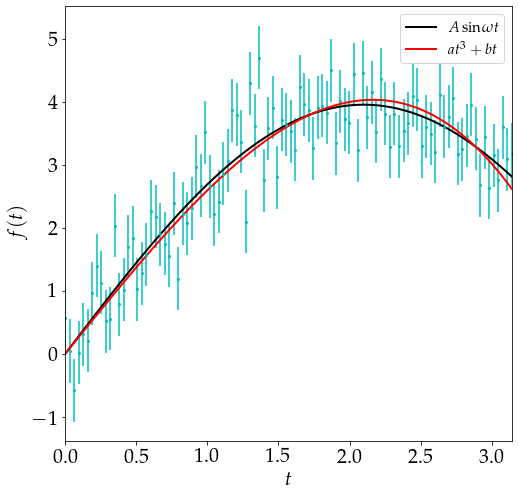

In [18]:
plt.figure(figsize=(8,8))
plt.errorbar(domain, data, yerr=sigma, fmt = 'co', markersize = 2)
plt.plot(grid, theory_1, lw = 2, c = 'k', label = label_model_1)
plt.plot(grid, theory_2, lw = 2, c = 'r', label = label_model_2)
plt.xlim(minx, maxx)
plt.xlabel(r'$t$', fontsize = fontSize)
plt.ylabel(r'$f(t)$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'upper right',prop={'family':'sans-serif', 'size':15})
# plt.savefig('results/data.pdf', bbox_inches = 'tight')
# plt.savefig('results/data.png', bbox_inches = 'tight')
plt.show()

### Repeated Experiments

In [19]:
evidence_bf = EvidenceAndBF(domain, fid1, fid2, noise_cov, prior_cov_1, prior_cov_2)

In [20]:
store_quantities = list()
for i in range(ntrials):
    data = data = evidence_bf.models.first_model.theory_fid + sigma*np.random.randn(ndata)
    calculations = evidence_bf.calculations(data)
    store_quantities.append(calculations)

In [21]:
dataframe = pd.DataFrame(store_quantities)

In [22]:
dataframe.head()

,evi_full_1,evi_full_2,evi_comp_1,evi_comp_2,bf_full,bf_comp
0,-83.125190,-84.332510,-17.999124,-19.206444,1.207320,1.207320
1,-88.858760,-90.065661,-17.999883,-19.206784,1.206901,1.206901
2,-82.001964,-83.209594,-17.999343,-19.206973,1.207630,1.207630
3,-89.305136,-90.512458,-17.999140,-19.206462,1.207322,1.207322
4,-82.079520,-83.286848,-17.999212,-19.206540,1.207328,1.207328


## Plots

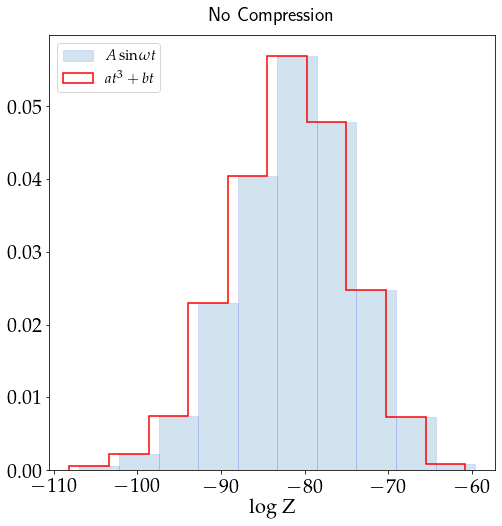

In [23]:
plt.figure(figsize = (8,8))
plt.title('No Compression', fontsize=fontSize, y=1.02)
plt.hist(dataframe['evi_full_1'].values, density = True, edgecolor='b', linewidth=0.5, label = label_model_1, alpha = 0.2)
plt.hist(dataframe['evi_full_2'].values, density = True, edgecolor='r', linewidth=1.5, label = label_model_2, histtype='step')
plt.xlabel(r'$\textrm{log Z}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
# plt.savefig('results/evidence_full_data.pdf', bbox_inches = 'tight')
# plt.savefig('results/evidence_full_data.png', bbox_inches = 'tight')
plt.show()

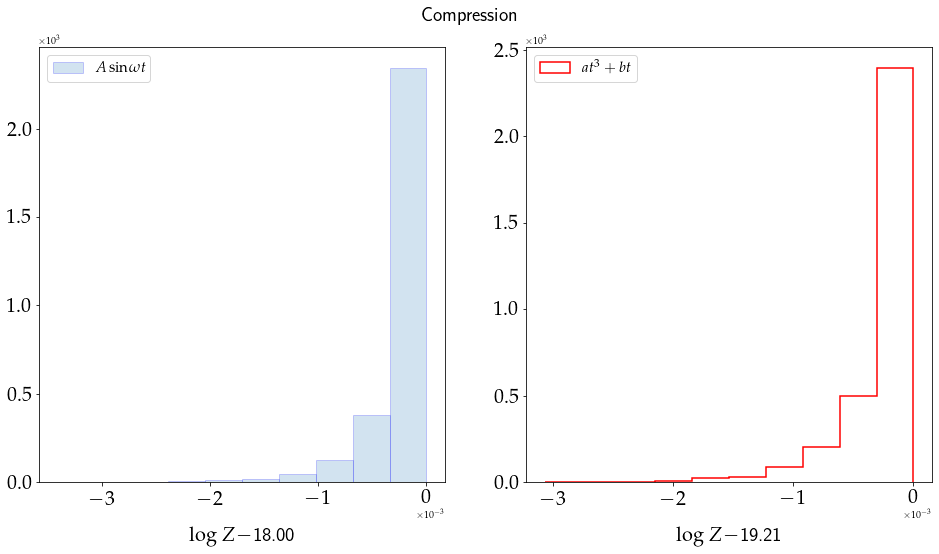

In [24]:
max_comp_first = max(dataframe['evi_comp_1'].values)
max_comp_second =max(dataframe['evi_comp_2'].values)

plt.figure(figsize = (16,8))
plt.suptitle('Compression', fontsize = fontSize, y=0.95)
plt.subplot(121)
plt.hist(dataframe['evi_comp_1'].values - max_comp_first, density = True, edgecolor='b', linewidth=1.0, label = label_model_1, alpha = 0.2)
plt.xlabel(r'$\textrm{log }Z-$' + f'{abs(max_comp_first):.2f}', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})

plt.subplot(122)
plt.hist(dataframe['evi_comp_2'].values - max_comp_second, density = True, edgecolor='r', linewidth=1.5, label = label_model_2, histtype='step')
plt.xlabel(r'$\textrm{log }Z-$' + f'{abs(max_comp_second):.2f}', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})

# plt.savefig('results/evidence_comp_data.pdf', bbox_inches = 'tight')
# plt.savefig('results/evidence_comp_data.png', bbox_inches = 'tight')
plt.show()

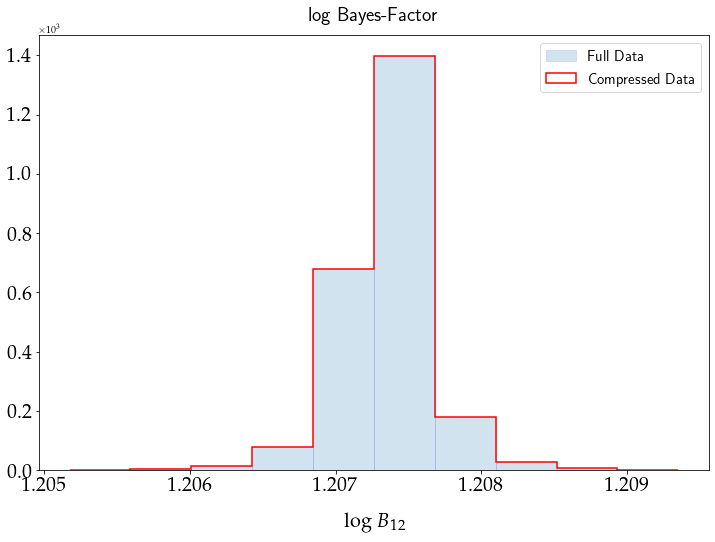

In [25]:
max_bf = max([max(dataframe['bf_full'].values), max(dataframe['bf_comp'].values)])
plt.figure(figsize = (12,8))
plt.title('log Bayes-Factor', fontsize=fontSize, y=1.02)
plt.hist(dataframe['bf_full'].values, density = True, edgecolor='b', linewidth=0.5, label = 'Full Data', alpha = 0.2)
plt.hist(dataframe['bf_comp'].values, density = True, edgecolor='r', linewidth=1.5, label = 'Compressed Data', histtype='step')
plt.xlabel(r'$\textrm{log }B_{12}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc = 'upper right',prop={'family':'sans-serif', 'size':15})
# plt.savefig('results/log-bayes-factor.pdf', bbox_inches = 'tight')
# plt.savefig('results/log-bayes-factor.png', bbox_inches = 'tight')
plt.show()